### Advantage-Actor-Critic
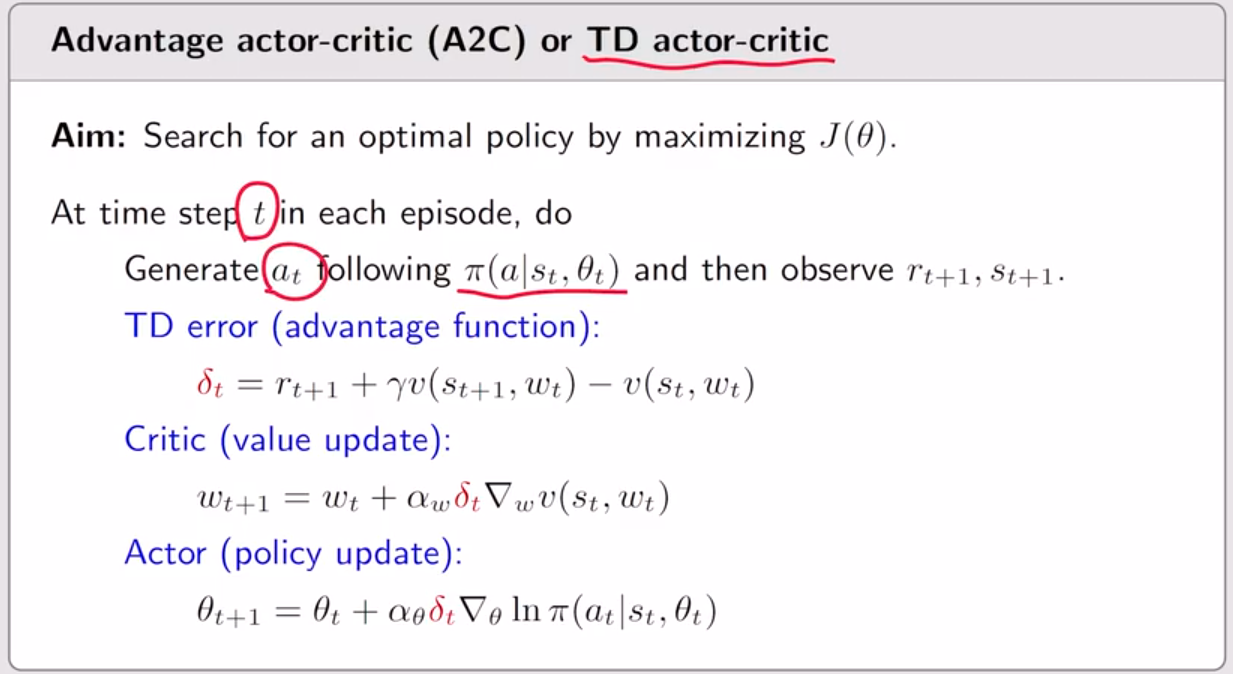

In [39]:
import gym
import matplotlib.pyplot as plt
import numpy as np
from math import cos, pi
import random
from itertools import product
from pprint import pprint

In [40]:
def evaluate_policy(env, agent):
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    terminated = False
    sum_reward = 0
    for _ in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, _ , info = env.step(a_k)
#         print(f"s_k: {s_k}, a_k: {a_k}, s_k1: {s_k1}, r_k: {r_k}, terminated: {terminated}")
        sum_reward += r_k
        s_k = s_k1
        if terminated:
            break
    return sum_reward
    

In [41]:
class LinearModel():
    def __init__(self, q_num):
        self.q_num = q_num  # 这个参数很神奇，大了小了都会影响训练效率，相当于49个参数，比起表格4*16=64个，少了15个参数
        self.omega = np.zeros(self.q_num**2)
    
    def val(self, s_k, a_k):
        return np.dot(self.grad(s_k, a_k), self.omega) 
        
    def grad(self, s_k, a_k):
        # normalize
        normal_sk = s_k/15
        normal_ak = a_k/3
        
        return np.array([cos(pi*(x[0]*normal_sk + x[1]*normal_ak)) for x in list(product(range(self.q_num), repeat=2))])

    def pprint(self):
        pprint([[round(self.val(i, j),3) for j in range(4)] for i in range(16)])


class PolicyModel(LinearModel):
    def __init__(self, q_num):
        super().__init__(q_num)
    
    def val(self, s_k: int, a_k: int) -> float:
        '''use parameterize policy'''
        h_func = [np.dot(self.omega, self.grad(s_k, i)) for i in range(4)]    
        pp = self.softmax(h_func)
        return pp[int(a_k)]
    
    def softmax(self, x):
        x_exp = np.exp(x)
        # 如果是列向量，则axis=0
        x_sum = np.sum(x_exp, axis=0, keepdims=True)
        s = x_exp / x_sum
        return s

    
class PolicyValueModel(LinearModel):
    def __init__(self, q_num):
        self.q_num = q_num  # 这个参数很神奇，大了小了都会影响训练效率，相当于49个参数，比起表格4*16=64个，少了15个参数
        self.omega = np.zeros(self.q_num**2)
    
    def val(self, s_k):
        return np.dot(self.grad(s_k), self.omega) 
        
    def grad(self, s_k):
        # normalize
        normal_sk = s_k/15
        
        return np.array([cos(pi*(x[0]*normal_sk)) for x in list(product(range(self.q_num), repeat=2))])

    def pprint(self):
        pprint([round(self.val(i)) for i in range(16)])
    

In [42]:
class Agent():
    def __init__(self, action_dim: int, state_dim: int, alpha=0.01, gamma=0.9):
        self.action_dim = action_dim
        self.state_dim = state_dim
        self.alpha = alpha
        self.gamma = gamma

        self.policy = PolicyModel(6)
        self.V = PolicyValueModel(15)
    
    def select_action(self, s_k: int) -> int:
        return random.choices(range(4), weights=[self.policy.val(s_k, ak) for ak in range(4)])[0]
    
    def train(self, s_k, a_k, r_k, s_k1):
        # policy evaluation
        delta = r_k + self.gamma * self.V.val(s_k1) - self.V.val(s_k)
        
        self.V.omega += self.alpha * delta * self.V.grad(s_k)
        
        # actor (policy update)
        delta_ln_policy = self.policy.grad(s_k, a_k) / self.policy.val(s_k, a_k)
        self.policy.omega += self.alpha * delta_ln_policy * delta
        
        

In [43]:
# parameter
cfg_params = {
    "env_name" : "FrozenLake-v1",
    "random_seed": 0,
    "max_train_steps": 2000,
    "max_episode_steps": 500,
}

env = gym.make(cfg_params["env_name"], desc=None, map_name="4x4", is_slippery=False) #  gym.make("CliffWalking-v0", render_mode="human")


In [46]:
# make it as a funtion for data analysis

agent = Agent(
    action_dim=env.action_space.n,
    state_dim=env.observation_space.n,
    alpha=0.02,
    gamma=0.9)

# training
score_queue = []

for k in range(cfg_params["max_train_steps"]):
    # reset t  he s_k
    s_k, info = env.reset(seed=cfg_params["random_seed"])
    # collect data set
    for ek in range(cfg_params["max_episode_steps"]):
        a_k = agent.select_action(s_k)
        s_k1, r_k, terminated, truncated, info = env.step(a_k)
        agent.train(s_k, a_k, r_k, s_k1)
        if terminated:
#             print(f"s_k: {s_k}, s_k1: {s_k1}, r_k: {r_k}, a_k: {a_k}, e_k : {ek}, terminated: {terminated}")
            break
        s_k = s_k1

    score = evaluate_policy(env, agent)
    score_queue.append(score)
    print(f'current step: {k}/{cfg_params["max_train_steps"]}, score: {score}')


current step: 0/2000, score: 0.0
current step: 1/2000, score: 0.0
current step: 2/2000, score: 0.0
current step: 3/2000, score: 0.0
current step: 4/2000, score: 0.0
current step: 5/2000, score: 0.0
current step: 6/2000, score: 0.0
current step: 7/2000, score: 0.0
current step: 8/2000, score: 0.0
current step: 9/2000, score: 0.0
current step: 10/2000, score: 0.0
current step: 11/2000, score: 0.0
current step: 12/2000, score: 0.0
current step: 13/2000, score: 0.0
current step: 14/2000, score: 0.0
current step: 15/2000, score: 0.0
current step: 16/2000, score: 0.0
current step: 17/2000, score: 0.0
current step: 18/2000, score: 0.0
current step: 19/2000, score: 0.0
current step: 20/2000, score: 0.0
current step: 21/2000, score: 0.0
current step: 22/2000, score: 0.0
current step: 23/2000, score: 0.0
current step: 24/2000, score: 0.0
current step: 25/2000, score: 0.0
current step: 26/2000, score: 0.0
current step: 27/2000, score: 0.0
current step: 28/2000, score: 0.0
current step: 29/2000, s

current step: 238/2000, score: 0.0
current step: 239/2000, score: 0.0
current step: 240/2000, score: 0.0
current step: 241/2000, score: 0.0
current step: 242/2000, score: 0.0
current step: 243/2000, score: 0.0
current step: 244/2000, score: 0.0
current step: 245/2000, score: 0.0
current step: 246/2000, score: 0.0
current step: 247/2000, score: 0.0
current step: 248/2000, score: 0.0
current step: 249/2000, score: 0.0
current step: 250/2000, score: 0.0
current step: 251/2000, score: 0.0
current step: 252/2000, score: 0.0
current step: 253/2000, score: 0.0
current step: 254/2000, score: 0.0
current step: 255/2000, score: 0.0
current step: 256/2000, score: 0.0
current step: 257/2000, score: 0.0
current step: 258/2000, score: 0.0
current step: 259/2000, score: 0.0
current step: 260/2000, score: 0.0
current step: 261/2000, score: 0.0
current step: 262/2000, score: 0.0
current step: 263/2000, score: 0.0
current step: 264/2000, score: 0.0
current step: 265/2000, score: 0.0
current step: 266/20

current step: 473/2000, score: 0.0
current step: 474/2000, score: 0.0
current step: 475/2000, score: 0.0
current step: 476/2000, score: 0.0
current step: 477/2000, score: 0.0
current step: 478/2000, score: 0.0
current step: 479/2000, score: 0.0
current step: 480/2000, score: 0.0
current step: 481/2000, score: 0.0
current step: 482/2000, score: 0.0
current step: 483/2000, score: 0.0
current step: 484/2000, score: 0.0
current step: 485/2000, score: 0.0
current step: 486/2000, score: 0.0
current step: 487/2000, score: 0.0
current step: 488/2000, score: 0.0
current step: 489/2000, score: 0.0
current step: 490/2000, score: 0.0
current step: 491/2000, score: 0.0
current step: 492/2000, score: 0.0
current step: 493/2000, score: 0.0
current step: 494/2000, score: 0.0
current step: 495/2000, score: 0.0
current step: 496/2000, score: 0.0
current step: 497/2000, score: 0.0
current step: 498/2000, score: 0.0
current step: 499/2000, score: 0.0
current step: 500/2000, score: 0.0
current step: 501/20

current step: 708/2000, score: 0.0
current step: 709/2000, score: 0.0
current step: 710/2000, score: 0.0
current step: 711/2000, score: 0.0
current step: 712/2000, score: 0.0
current step: 713/2000, score: 0.0
current step: 714/2000, score: 0.0
current step: 715/2000, score: 0.0
current step: 716/2000, score: 0.0
current step: 717/2000, score: 0.0
current step: 718/2000, score: 0.0
current step: 719/2000, score: 0.0
current step: 720/2000, score: 0.0
current step: 721/2000, score: 0.0
current step: 722/2000, score: 0.0
current step: 723/2000, score: 0.0
current step: 724/2000, score: 0.0
current step: 725/2000, score: 0.0
current step: 726/2000, score: 0.0
current step: 727/2000, score: 0.0
current step: 728/2000, score: 0.0
current step: 729/2000, score: 0.0
current step: 730/2000, score: 0.0
current step: 731/2000, score: 0.0
current step: 732/2000, score: 0.0
current step: 733/2000, score: 0.0
current step: 734/2000, score: 0.0
current step: 735/2000, score: 0.0
current step: 736/20

current step: 943/2000, score: 0.0
current step: 944/2000, score: 0.0
current step: 945/2000, score: 0.0
current step: 946/2000, score: 0.0
current step: 947/2000, score: 0.0
current step: 948/2000, score: 0.0
current step: 949/2000, score: 0.0
current step: 950/2000, score: 0.0
current step: 951/2000, score: 0.0
current step: 952/2000, score: 0.0
current step: 953/2000, score: 0.0
current step: 954/2000, score: 0.0
current step: 955/2000, score: 0.0
current step: 956/2000, score: 0.0
current step: 957/2000, score: 0.0
current step: 958/2000, score: 0.0
current step: 959/2000, score: 0.0
current step: 960/2000, score: 0.0
current step: 961/2000, score: 0.0
current step: 962/2000, score: 0.0
current step: 963/2000, score: 0.0
current step: 964/2000, score: 0.0
current step: 965/2000, score: 0.0
current step: 966/2000, score: 0.0
current step: 967/2000, score: 0.0
current step: 968/2000, score: 0.0
current step: 969/2000, score: 0.0
current step: 970/2000, score: 0.0
current step: 971/20

current step: 1174/2000, score: 0.0
current step: 1175/2000, score: 0.0
current step: 1176/2000, score: 0.0
current step: 1177/2000, score: 0.0
current step: 1178/2000, score: 0.0
current step: 1179/2000, score: 0.0
current step: 1180/2000, score: 0.0
current step: 1181/2000, score: 0.0
current step: 1182/2000, score: 0.0
current step: 1183/2000, score: 0.0
current step: 1184/2000, score: 0.0
current step: 1185/2000, score: 0.0
current step: 1186/2000, score: 0.0
current step: 1187/2000, score: 0.0
current step: 1188/2000, score: 0.0
current step: 1189/2000, score: 0.0
current step: 1190/2000, score: 0.0
current step: 1191/2000, score: 0.0
current step: 1192/2000, score: 0.0
current step: 1193/2000, score: 0.0
current step: 1194/2000, score: 0.0
current step: 1195/2000, score: 0.0
current step: 1196/2000, score: 0.0
current step: 1197/2000, score: 0.0
current step: 1198/2000, score: 0.0
current step: 1199/2000, score: 0.0
current step: 1200/2000, score: 0.0
current step: 1201/2000, sco

current step: 1402/2000, score: 0.0
current step: 1403/2000, score: 0.0
current step: 1404/2000, score: 0.0
current step: 1405/2000, score: 0.0
current step: 1406/2000, score: 0.0
current step: 1407/2000, score: 0.0
current step: 1408/2000, score: 0.0
current step: 1409/2000, score: 0.0
current step: 1410/2000, score: 0.0
current step: 1411/2000, score: 0.0
current step: 1412/2000, score: 0.0
current step: 1413/2000, score: 0.0
current step: 1414/2000, score: 0.0
current step: 1415/2000, score: 0.0
current step: 1416/2000, score: 0.0
current step: 1417/2000, score: 0.0
current step: 1418/2000, score: 0.0
current step: 1419/2000, score: 0.0
current step: 1420/2000, score: 0.0
current step: 1421/2000, score: 0.0
current step: 1422/2000, score: 0.0
current step: 1423/2000, score: 0.0
current step: 1424/2000, score: 0.0
current step: 1425/2000, score: 0.0
current step: 1426/2000, score: 0.0
current step: 1427/2000, score: 0.0
current step: 1428/2000, score: 0.0
current step: 1429/2000, sco

current step: 1630/2000, score: 0.0
current step: 1631/2000, score: 0.0
current step: 1632/2000, score: 0.0
current step: 1633/2000, score: 0.0
current step: 1634/2000, score: 0.0
current step: 1635/2000, score: 0.0
current step: 1636/2000, score: 0.0
current step: 1637/2000, score: 0.0
current step: 1638/2000, score: 0.0
current step: 1639/2000, score: 0.0
current step: 1640/2000, score: 0.0
current step: 1641/2000, score: 0.0
current step: 1642/2000, score: 0.0
current step: 1643/2000, score: 0.0
current step: 1644/2000, score: 0.0
current step: 1645/2000, score: 0.0
current step: 1646/2000, score: 0.0
current step: 1647/2000, score: 0.0
current step: 1648/2000, score: 0.0
current step: 1649/2000, score: 0.0
current step: 1650/2000, score: 0.0
current step: 1651/2000, score: 0.0
current step: 1652/2000, score: 0.0
current step: 1653/2000, score: 0.0
current step: 1654/2000, score: 0.0
current step: 1655/2000, score: 0.0
current step: 1656/2000, score: 0.0
current step: 1657/2000, sco

current step: 1860/2000, score: 0.0
current step: 1861/2000, score: 0.0
current step: 1862/2000, score: 0.0
current step: 1863/2000, score: 0.0
current step: 1864/2000, score: 0.0
current step: 1865/2000, score: 0.0
current step: 1866/2000, score: 0.0
current step: 1867/2000, score: 0.0
current step: 1868/2000, score: 0.0
current step: 1869/2000, score: 0.0
current step: 1870/2000, score: 0.0
current step: 1871/2000, score: 0.0
current step: 1872/2000, score: 0.0
current step: 1873/2000, score: 0.0
current step: 1874/2000, score: 0.0
current step: 1875/2000, score: 0.0
current step: 1876/2000, score: 0.0
current step: 1877/2000, score: 0.0
current step: 1878/2000, score: 0.0
current step: 1879/2000, score: 0.0
current step: 1880/2000, score: 0.0
current step: 1881/2000, score: 0.0
current step: 1882/2000, score: 0.0
current step: 1883/2000, score: 0.0
current step: 1884/2000, score: 0.0
current step: 1885/2000, score: 0.0
current step: 1886/2000, score: 0.0
current step: 1887/2000, sco

In [14]:
agent.V.pprint()

[23, 24, 26, 27, 26, 24, 23, 25, 29, 31, 32, 32, 32, 34, 36, 37]


In [45]:
agent.policy.pprint()

[[0.025, 0.619, 0.306, 0.05],
 [0.029, 0.62, 0.307, 0.044],
 [0.046, 0.544, 0.37, 0.04],
 [0.083, 0.413, 0.462, 0.042],
 [0.123, 0.273, 0.552, 0.052],
 [0.132, 0.172, 0.63, 0.066],
 [0.11, 0.125, 0.69, 0.076],
 [0.09, 0.131, 0.703, 0.076],
 [0.088, 0.209, 0.624, 0.078],
 [0.095, 0.371, 0.449, 0.085],
 [0.099, 0.502, 0.308, 0.091],
 [0.1, 0.488, 0.313, 0.099],
 [0.088, 0.344, 0.48, 0.088],
 [0.058, 0.188, 0.704, 0.05],
 [0.039, 0.13, 0.803, 0.028],
 [0.042, 0.172, 0.759, 0.028]]


In [13]:
evaluate_env = gym.make(cfg_params["env_name"], render_mode="human",desc=None, map_name="4x4", is_slippery=False)
evaluate_policy(evaluate_env, agent)

0.0